# EDA для данных по New York Taxi

## Загрузка библиотек и датасетов

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost.core import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor

import joblib

In [2]:
dataset = pd.read_csv("data/train.csv")
print(f"Dataset shape: {dataset.shape}")
display(dataset.info())
dataset.head()

Dataset shape: (250000, 11)
<class 'pandas.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  250000 non-null  str    
 1   vendor_id           250000 non-null  int64  
 2   pickup_datetime     250000 non-null  str    
 3   dropoff_datetime    250000 non-null  str    
 4   passenger_count     250000 non-null  int64  
 5   pickup_longitude    250000 non-null  float64
 6   pickup_latitude     250000 non-null  float64
 7   dropoff_longitude   250000 non-null  float64
 8   dropoff_latitude    250000 non-null  float64
 9   store_and_fwd_flag  250000 non-null  str    
 10  trip_duration       250000 non-null  int64  
dtypes: float64(4), int64(3), str(4)
memory usage: 21.0 MB


None

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
# Обрезаем данные, чтобы они влезли в гитхаб
# dataset = dataset.iloc[:250000]
# dataset.to_csv("data/train.csv", index=None)
# dataset

In [4]:
test_dataset = pd.read_csv("data/test.csv")
print(f"Test Dataset shape: {test_dataset.shape}")
display(test_dataset.info())
test_dataset.head()

Test Dataset shape: (250000, 9)
<class 'pandas.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  250000 non-null  str    
 1   vendor_id           250000 non-null  int64  
 2   pickup_datetime     250000 non-null  str    
 3   passenger_count     250000 non-null  int64  
 4   pickup_longitude    250000 non-null  float64
 5   pickup_latitude     250000 non-null  float64
 6   dropoff_longitude   250000 non-null  float64
 7   dropoff_latitude    250000 non-null  float64
 8   store_and_fwd_flag  250000 non-null  str    
dtypes: float64(4), int64(2), str(3)
memory usage: 17.2 MB


None

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
# Обрезаем данные, чтобы они влезли в гитхаб
# test_dataset = test_dataset.iloc[:250000]
# test_dataset.to_csv("data/test.csv", index=None)
# test_dataset

## Базовый анализ пропусков и обработка выбросов

In [6]:
# Проверка на то, что датасеты не имеют пропусков
assert dataset.isna().sum().sum() == 0
assert test_dataset.isna().sum().sum() == 0

In [7]:
# Проверка дубликатов
assert dataset.duplicated().sum() == 0
assert test_dataset.duplicated().sum() == 0

Теперь перейдём к осмотру целевой переменной. Возможно, в ней найдутся какие-то странные аномалии.

In [8]:
# Смотрим целевую переменную
dataset['trip_duration'].describe()

count    250000.000000
mean        946.698028
std        3098.481564
min           1.000000
25%         396.000000
50%         661.000000
75%        1073.000000
max       86390.000000
Name: trip_duration, dtype: float64

In [9]:
# Посмотрим на перцентили, чтобы понять, где начинаются реальные аномалии
percentiles = [0.001, 0.01, 0.05, 0.5, 0.95, 0.99, 0.999]
print("Квантили trip_duration (в секундах):")
print(dataset['trip_duration'].quantile(percentiles))

# Отрежем только самые экстремальные 0.1% данных снизу и сверху
q_low = dataset['trip_duration'].quantile(0.001)
q_high = dataset['trip_duration'].quantile(0.999)

new_dataset = dataset[(dataset['trip_duration'] >= q_low) & (dataset['trip_duration'] <= q_high)]
new_dataset.shape

Квантили trip_duration (в секундах):
0.001        8.000
0.010       87.000
0.050      180.000
0.500      661.000
0.950     2099.000
0.990     3413.010
0.999    84429.026
Name: trip_duration, dtype: float64


(249502, 11)

Да, у нас получились слишком экстремальные значения (7 секунд и 85128 секунд в экстремальных значениях), которые почти наверняка выглядят как выброс. Нужно рассмотреть их далее, в том числе распределение и взаимосвязь с другими признаками, чтобы точно удостовериться, что это выбросы.

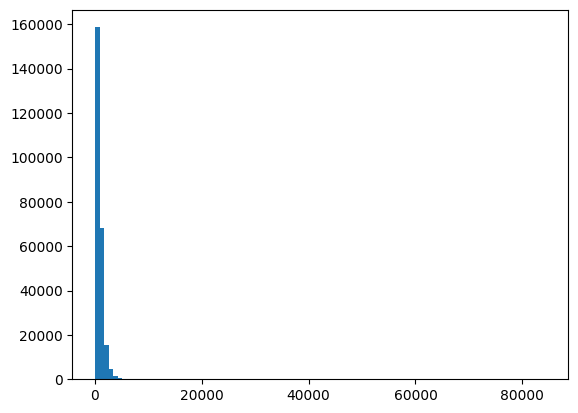

In [10]:
# Проверка на выбросы целевой переменной
plt.hist(new_dataset['trip_duration'], bins=100)
plt.show()

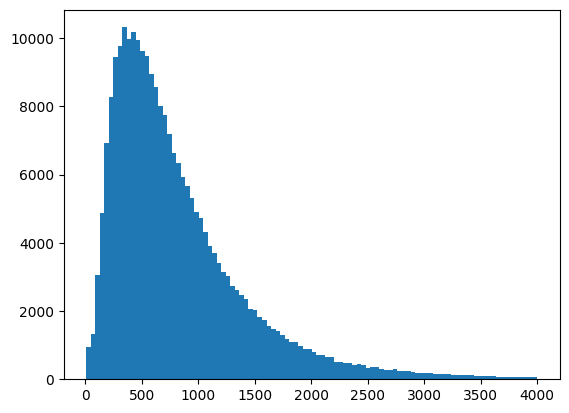

In [11]:
no_bigs = new_dataset[new_dataset['trip_duration'] < 4000]
plt.hist(no_bigs['trip_duration'], bins=100)
plt.show()

Исходя из представленного выше графика видно, что данных, в которых `trip_duration` превышает 4000 (примерно 1 час и 6 минут), очень мало. Считать ли их выбросами -- вопрос достаточно серьёзный, нужно рассмотреть эти данные дальше, глянутЬ, чем их данные отличаются от исходных.

Посмотрим теперь на низких значениях.

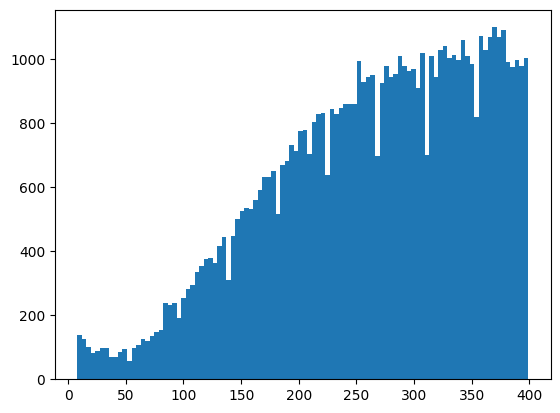

In [12]:
small_values = new_dataset[new_dataset['trip_duration'] < 400]
plt.hist(small_values['trip_duration'], bins=100)
plt.show()

На данном графике заметно аномально большое количество поездок до 50 секунд, при том это число возрастает ближе к 0 (на оригинальных данных из `dataset` всё было такеж). Вероятно, баг системы, либо же слишком короткая поездка, надо глянуть это дальше. 

In [13]:
# Находим границы по 99.9% данных
lon_min, lon_max = new_dataset['pickup_longitude'].quantile(0.001), new_dataset['pickup_longitude'].quantile(0.999)
lat_min, lat_max = new_dataset['pickup_latitude'].quantile(0.001), new_dataset['pickup_latitude'].quantile(0.999)

print(f"Data-driven Bounding Box Нью-Йорка:")
print(f"Долгота (Longitude): от {lon_min:.4f} до {lon_max:.4f}")
print(f"Широта (Latitude): от {lat_min:.4f} до {lat_max:.4f}")

# Очищаем данные от выходящих за границы геолокаций Нью-Йорка
new_dataset = new_dataset[
    (new_dataset['pickup_longitude'].between(lon_min, lon_max)) &
    (new_dataset['dropoff_longitude'].between(lon_min, lon_max)) &
    (new_dataset['pickup_latitude'].between(lat_min, lat_max)) &
    (new_dataset['dropoff_latitude'].between(lat_min, lat_max))
]

Data-driven Bounding Box Нью-Йорка:
Долгота (Longitude): от -74.0172 до -73.7767
Широта (Latitude): от 40.6415 до 40.8432


In [14]:
display(dataset.shape)
display(new_dataset.shape)

(250000, 11)

(244274, 11)

Очистили 25 тысяч данных уже, осталось ещё немного почистить их от других видов выбросов: по времени от расстояния.

Для этого можем попробовать завести несколько дополнительных переменных (заняться Feature-Engineering-ом):
1) Длина маршрута по расстоянию [Гаверсина](https://progler.ru/blog/formula-haversina-dlya-nahozhdeniya-rasstoyaniya-mezhdu-dvumya-tochkami-na-sfere) (т.к. у нас координаты широты и долготы на Земле, значит нам нужно считать расстояние на сфере)
2) Длина маршрута по Манхеттеновскому расстоянию (т.к. у нас дорога из пункта А в пункт Б не прямые, улицы у нас расположены перпендикулярно)
2) Скорость поездки -- длина маршрута на длительность поездки (уникальное только для текущего анализа выбросов)

Потом по этим двум переменным можно будет рассмотреть аномальные поездки, где либо такси долго стояло и не двигалось, либо же ехало слишком быстро для реалий города (200+ км/ч)

In [15]:
# Страшная функция страшной функции
def haversine_distance(lng1, lat1, lng2, lat2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # радиус Земли в км
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


def manhattan_distance(lng1, lat1, lng2, lat2):
    a = haversine_distance(lng1, lat1, lng2, lat1)
    b = haversine_distance(lng1, lat1, lng1, lat2)
    return a + b

In [16]:
new_dataset["distance"] = manhattan_distance(
    new_dataset['pickup_longitude'],
    new_dataset['pickup_latitude'],
    new_dataset['dropoff_longitude'],
    new_dataset['dropoff_latitude'],
)
new_dataset['speed'] = new_dataset['distance'] / new_dataset['trip_duration'] * 3600 # домножаем, чтобы получились км\с
new_dataset.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.735433,13.730901
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2.430506,13.197318
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,8.203575,13.904365
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.661331,13.941241
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.199457,9.926539


In [17]:
# Теперь попробуем почистить выбросы с помощью изолированного леса
# Мы специально создали более интерпретируемые фичи под него, поэтому можно будет легко найти выделяющиеся значения и потом их отсечь
iso_features = ["distance", "speed", "trip_duration"]
iso_data = new_dataset[iso_features]

iso_forest = IsolationForest(contamination=0.01, random_state = 42, n_jobs=-1) # contamination -- процент выбросов
outliers_preds = iso_forest.fit_predict(iso_data)
new_dataset["outliers"] = outliers_preds
clean_dataset = new_dataset[new_dataset["outliers"] == 1].drop(columns="outliers")

display(dataset.shape)
display(clean_dataset.shape)

(250000, 11)

(241838, 13)

Мы выбросили аномалии из данных, теперь можем работать с ними дальше. Посмотрим снова на распределение целевой переменной, после чего перейдём к анализу признаков. Будем пытаться выделить кластеры, где люди в основном садятся на такси и где люди высаживаются из такси, потом выделить конкретные дни недели/часы, в которые чаще всего происходит час пик.

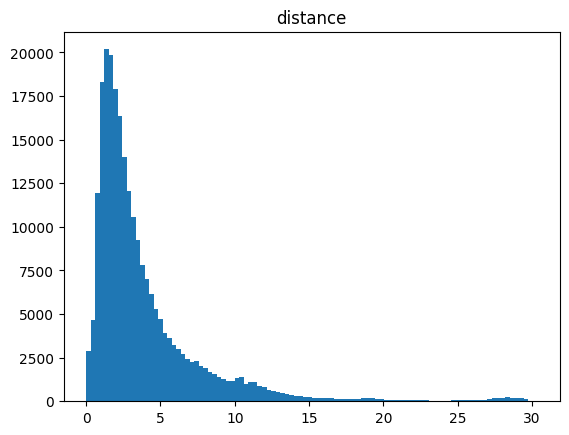

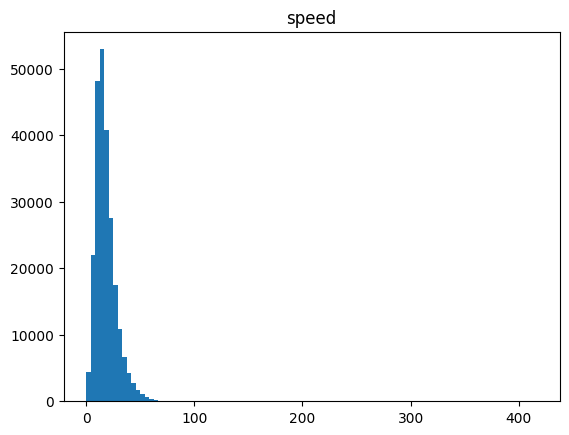

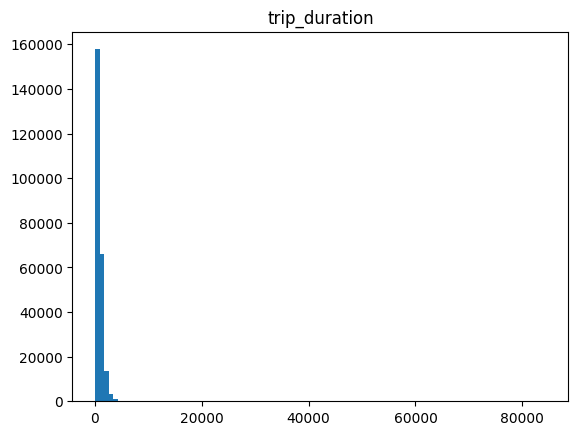

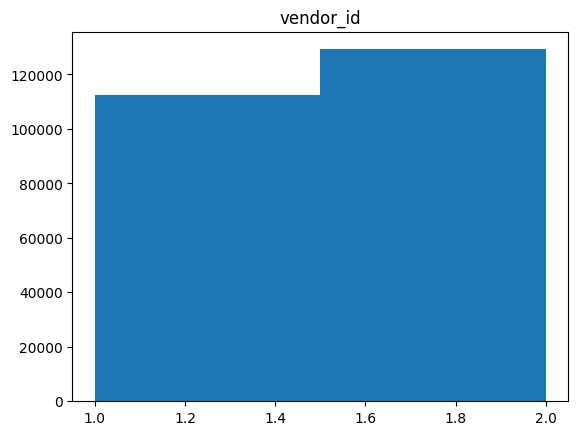

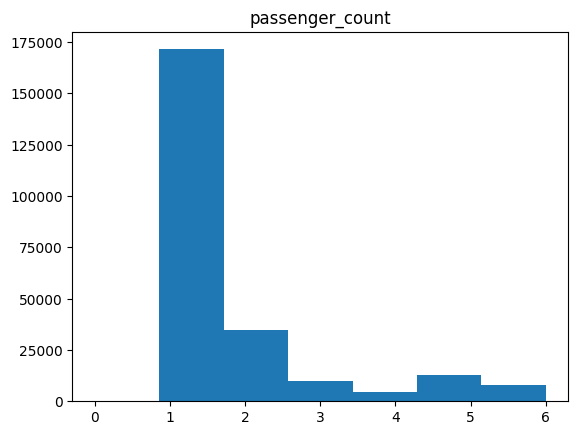

In [18]:
cols_1d = [
    "distance",
    "speed",
    "trip_duration",
    "vendor_id",
    "passenger_count"
]

for col in cols_1d:
    plt.hist(clean_dataset[col], bins=min(100, clean_dataset[col].nunique()))
    plt.title(col)
    plt.show()

In [19]:
# Аномалии всё ещё остались, нужно их дочистить
clean_dataset = clean_dataset[clean_dataset["speed"] < 100]
clean_dataset = clean_dataset[clean_dataset["speed"] > 0]
clean_dataset = clean_dataset[clean_dataset["passenger_count"] > 0]
clean_dataset = clean_dataset[clean_dataset["trip_duration"] < 5000]
clean_dataset.shape

(240881, 13)

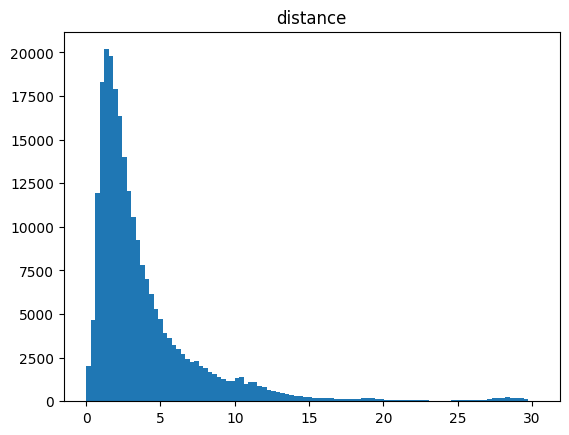

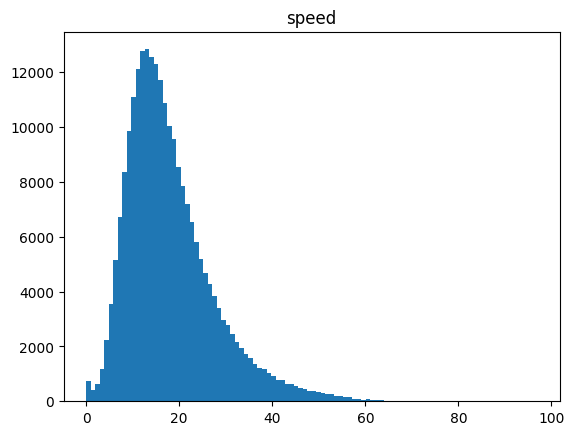

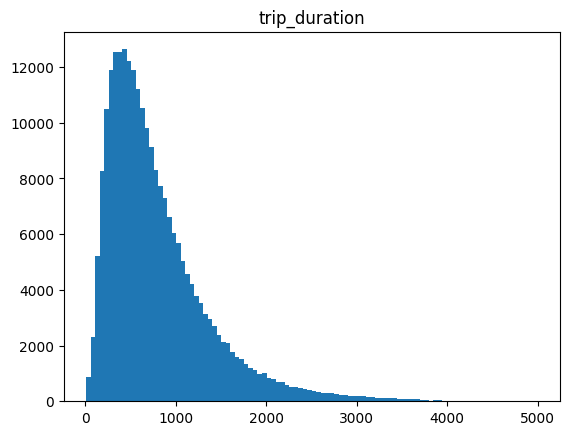

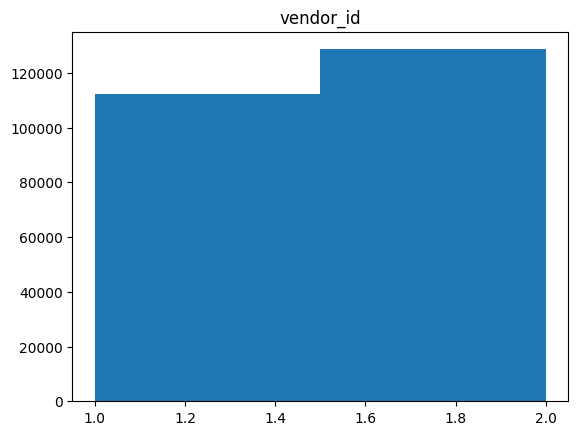

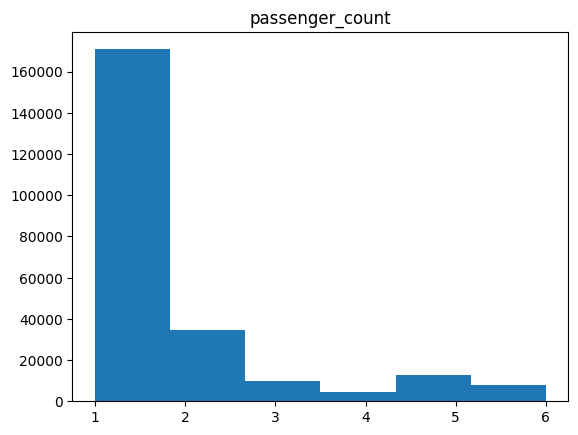

In [20]:
cols_1d = [
    "distance",
    "speed",
    "trip_duration",
    "vendor_id",
    "passenger_count"
]

for col in cols_1d:
    plt.hist(clean_dataset[col], bins=min(100, clean_dataset[col].nunique()))
    plt.title(col)
    plt.show()

Попробуем разделить дату и время на разные составляющие, чтобы глянуть распределение поездок по разным периодическим величинам:
- По времени (в рабочее время чаще обычного час пик)
- По дню неделю (в выходные нагрузка выше)
- По месяцам (зимой должно быть сложнее, чем летом, особенно перед новым годом)

In [21]:
clean_dataset['pickup_datetime'] = pd.to_datetime(clean_dataset['pickup_datetime'])
clean_dataset['pickup_hour'] = clean_dataset['pickup_datetime'].dt.hour
clean_dataset['pickup_dayofweek'] = clean_dataset['pickup_datetime'].dt.dayofweek
clean_dataset['pickup_month'] = clean_dataset['pickup_datetime'].dt.month

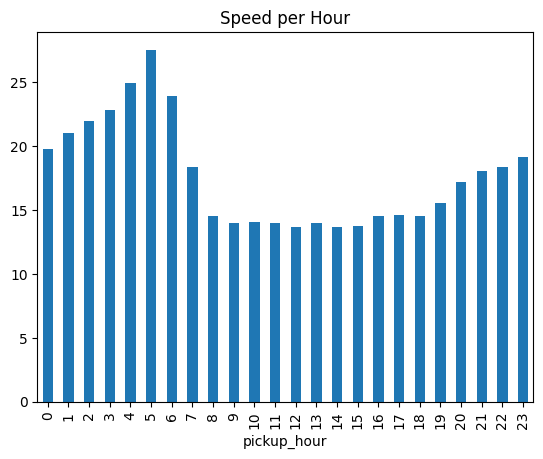

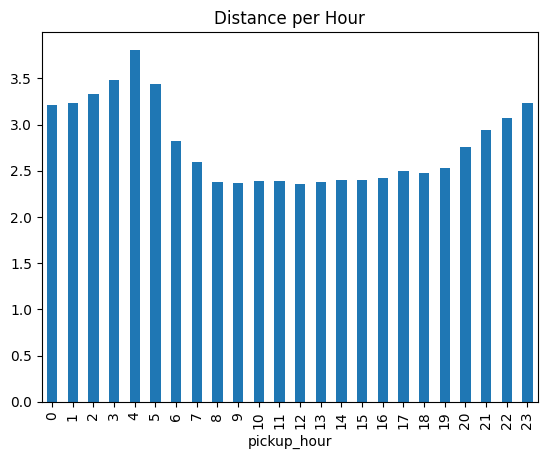

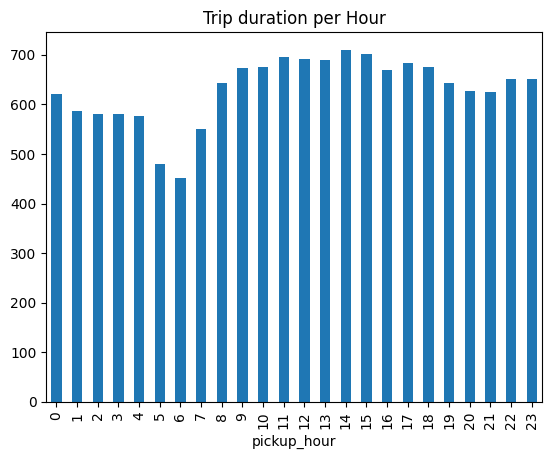

In [22]:
hourly_speed = clean_dataset.groupby('pickup_hour')['speed'].median()
hourly_speed.plot(kind='bar')
plt.title("Speed per Hour")
plt.show()

hourly_distance = clean_dataset.groupby('pickup_hour')['distance'].median()
hourly_distance.plot(kind='bar')
plt.title("Distance per Hour")
plt.show()

hourly_trip = clean_dataset.groupby('pickup_hour')['trip_duration'].median()
hourly_trip.plot(kind='bar')
plt.title("Trip duration per Hour")
plt.show()

Зависимость от часа заметная: перед началом рабочего дня заметен провал во времени поездки, это нормально, люди только просыпаются на работу, а во время рабочих часов (с 8 до 18) время поездки увеличивается, люди стараются на которые расстояния перемещаться, но при этом из-за большого потока не могут позволить себе высокую скорость.

Посмотрим теперь то, что у нас со статистикой по месяцам.

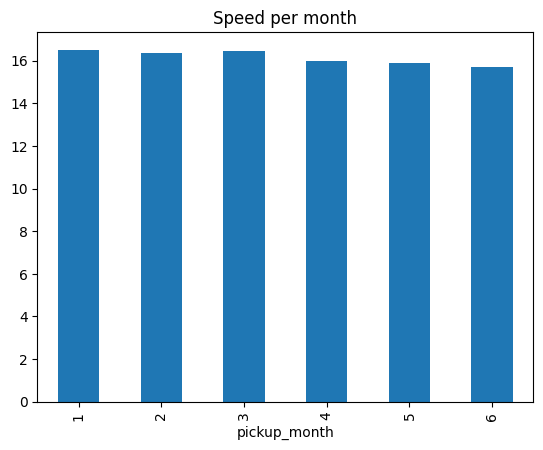

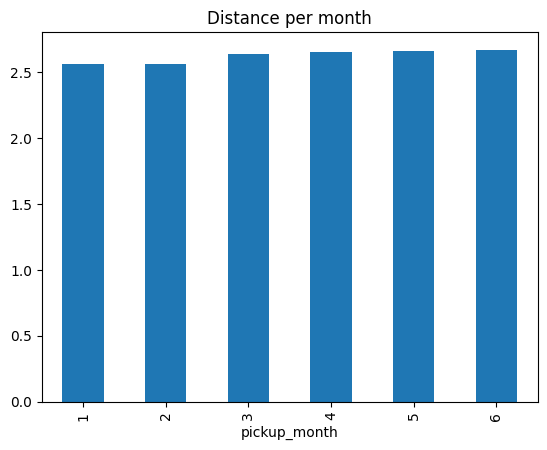

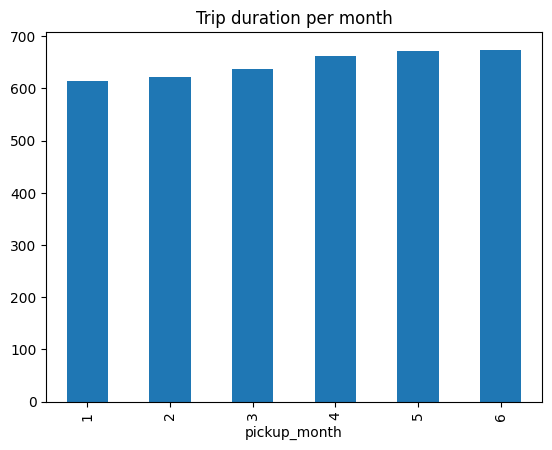

In [23]:
month_speed = clean_dataset.groupby('pickup_month')['speed'].median()
month_speed.plot(kind='bar')
plt.title("Speed per month")
plt.show()

month_distance = clean_dataset.groupby('pickup_month')['distance'].median()
month_distance.plot(kind='bar')
plt.title("Distance per month")
plt.show()

month_trip = clean_dataset.groupby('pickup_month')['trip_duration'].median()
month_trip.plot(kind='bar')
plt.title("Trip duration per month")
plt.show()

Зависимость от месяцев есть, но слабая. Данных недостаточно, данные представлены только за полгода, поэтому не понятна полная динамика. Вероятно, как признак отдельно выделять не стоит.

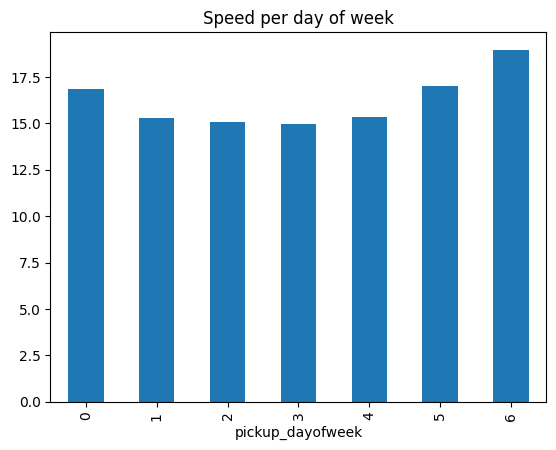

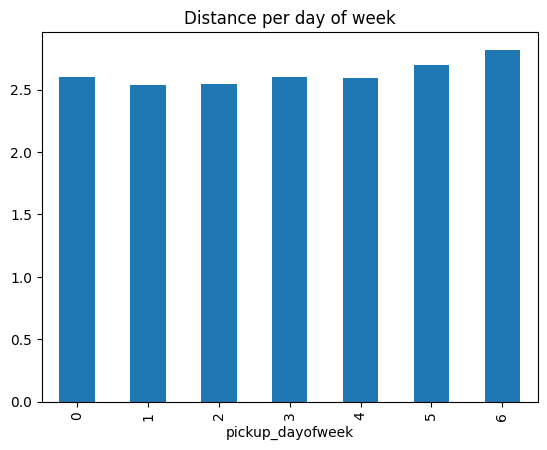

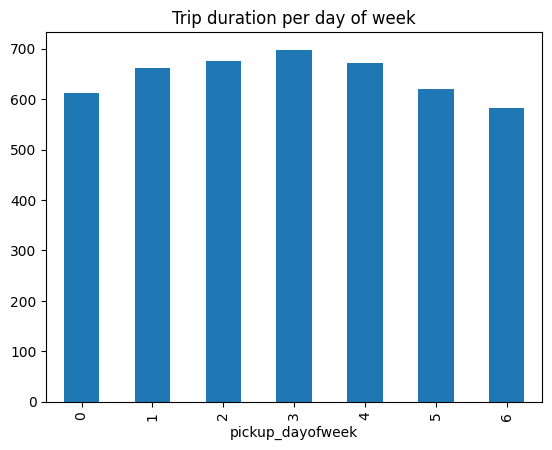

In [24]:
dayweek_speed = clean_dataset.groupby('pickup_dayofweek')['speed'].median()
dayweek_speed.plot(kind='bar')
plt.title("Speed per day of week")
plt.show()

dayweek_distance = clean_dataset.groupby('pickup_dayofweek')['distance'].median()
dayweek_distance.plot(kind='bar')
plt.title("Distance per day of week")
plt.show()

dayweek_trip = clean_dataset.groupby('pickup_dayofweek')['trip_duration'].median()
dayweek_trip.plot(kind='bar')
plt.title("Trip duration per day of week")
plt.show()

Зависимость от дня недели тоже заметна -- в рабочие дни люди ездят медленнее, на меньшие расстояния, и в сумме получается из-за большого потока люди долго ездят.

А по выходным люди уезжают куда-то далеко, и потом низкий, поэтому могут позволить себе ездить быстрее (в среднем).

In [25]:
# Создаем сетку (узлы графа), округляя координаты
clean_dataset['pu_lat_r'] = clean_dataset['pickup_latitude'].round(2)
clean_dataset['pu_lon_r'] = clean_dataset['pickup_longitude'].round(2)
clean_dataset['do_lat_r'] = clean_dataset['dropoff_latitude'].round(2)
clean_dataset['do_lon_r'] = clean_dataset['dropoff_longitude'].round(2)

# Агрегируем данные: считаем количество поездок, среднее время и среднее расстояние
routes = clean_dataset.groupby(['pu_lat_r', 'pu_lon_r', 'do_lat_r', 'do_lon_r']).agg(
    trips_count=('trip_duration', 'count'),
    avg_duration=('trip_duration', 'mean'),
    avg_distance=('distance', 'mean')
).reset_index()

# Оставляем только те маршруты, где есть движение, и отбираем топ-2000 популярных
routes = routes[routes['avg_distance'] > 0.5] # Убираем поездки внутри одного квадрата
top_routes = routes.nlargest(2000, 'trips_count')

print(f"Сформировано {len(top_routes)} уникальных маршрутов для отрисовки графа.")
display(top_routes.head(3))

Сформировано 2000 уникальных маршрутов для отрисовки графа.


,pu_lat_r,pu_lon_r,do_lat_r,do_lon_r,trips_count,avg_duration,avg_distance
6734,40.75,-73.99,40.76,-73.98,1449,585.563837,1.980540
8414,40.76,-73.97,40.77,-73.96,1240,386.856452,1.862165
8144,40.76,-73.98,40.75,-73.99,1234,646.543760,2.007194


/tmp/ipykernel_399/930751390.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm') # От синего (быстро) к красному (долго)


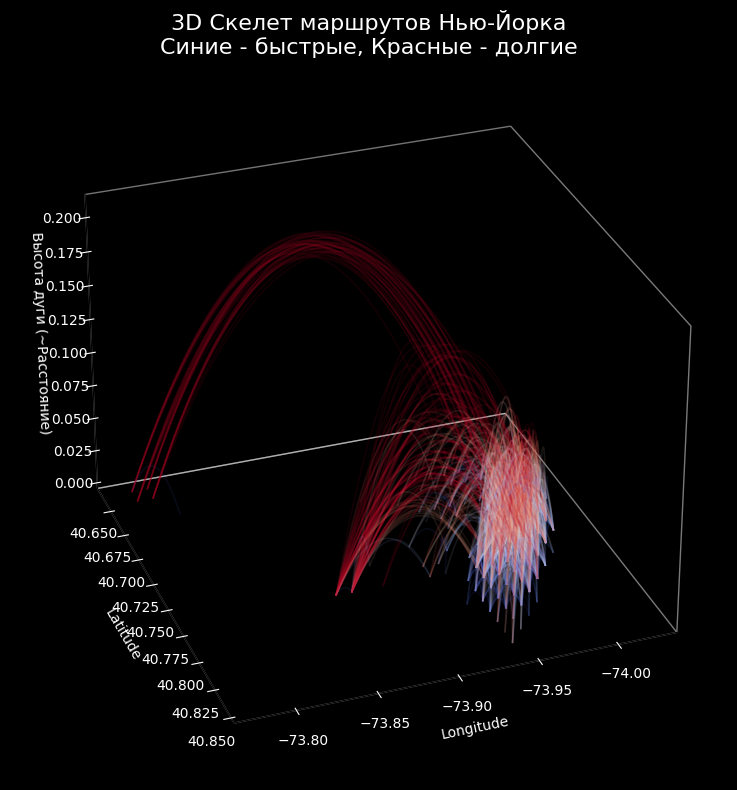

In [26]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black') # Черный фон для эффектности графа
fig.patch.set_facecolor('black')

norm_color = Normalize(vmin=top_routes['avg_duration'].quantile(0.1),
                       vmax=top_routes['avg_duration'].quantile(0.9))
norm_alpha = Normalize(vmin=top_routes['trips_count'].min(),
                       vmax=top_routes['trips_count'].max())

cmap = cm.get_cmap('coolwarm') # От синего (быстро) к красному (долго)
t = np.linspace(0, 1, 50)

for _, row in top_routes.iterrows():
    x1, y1 = row['pu_lon_r'], row['pu_lat_r']
    x2, y2 = row['do_lon_r'], row['do_lat_r']

    x_curve = x1 + t * (x2 - x1)
    y_curve = y1 + t * (y2 - y1)

    h = (row['avg_distance'] / 111.0) * 0.8
    z_curve = h * 4 * t * (1 - t)

    color = cmap(norm_color(row['avg_duration']))
    alpha = 0.1 + norm_alpha(row['trips_count']) * 0.7

    ax.plot(x_curve, y_curve, z_curve, color=color, alpha=alpha, linewidth=1.2)

ax.set_title("3D Скелет маршрутов Нью-Йорка\nСиние - быстрые, Красные - долгие", color='white', size=16)
ax.set_xlabel('Longitude', color='white')
ax.set_ylabel('Latitude', color='white')
ax.set_zlabel('Высота дуги (~Расстояние)', color='white')

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.tick_params(colors='white')

# Подбираем угол обзора: смотрим немного сверху и сбоку
ax.view_init(elev=30, azim=70)

plt.tight_layout()
plt.show()

Какая-то структура наблюдается, нужно попробовать кластеризовать всё по районам, т.к. пока что читаемость низкая.

In [27]:
coords = np.vstack((
    clean_dataset[['pickup_latitude', 'pickup_longitude']].values,
    clean_dataset[['dropoff_latitude', 'dropoff_longitude']].values
))

print(f"Форма объединенного массива координат: {coords.shape}")
kmeans = MiniBatchKMeans(n_clusters=100, random_state=42, batch_size=10000)
kmeans.fit(coords)

clean_dataset['pickup_cluster'] = kmeans.predict(clean_dataset[['pickup_latitude', 'pickup_longitude']])
clean_dataset['dropoff_cluster'] = kmeans.predict(clean_dataset[['dropoff_latitude', 'dropoff_longitude']])

Форма объединенного массива координат: (481762, 2)


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


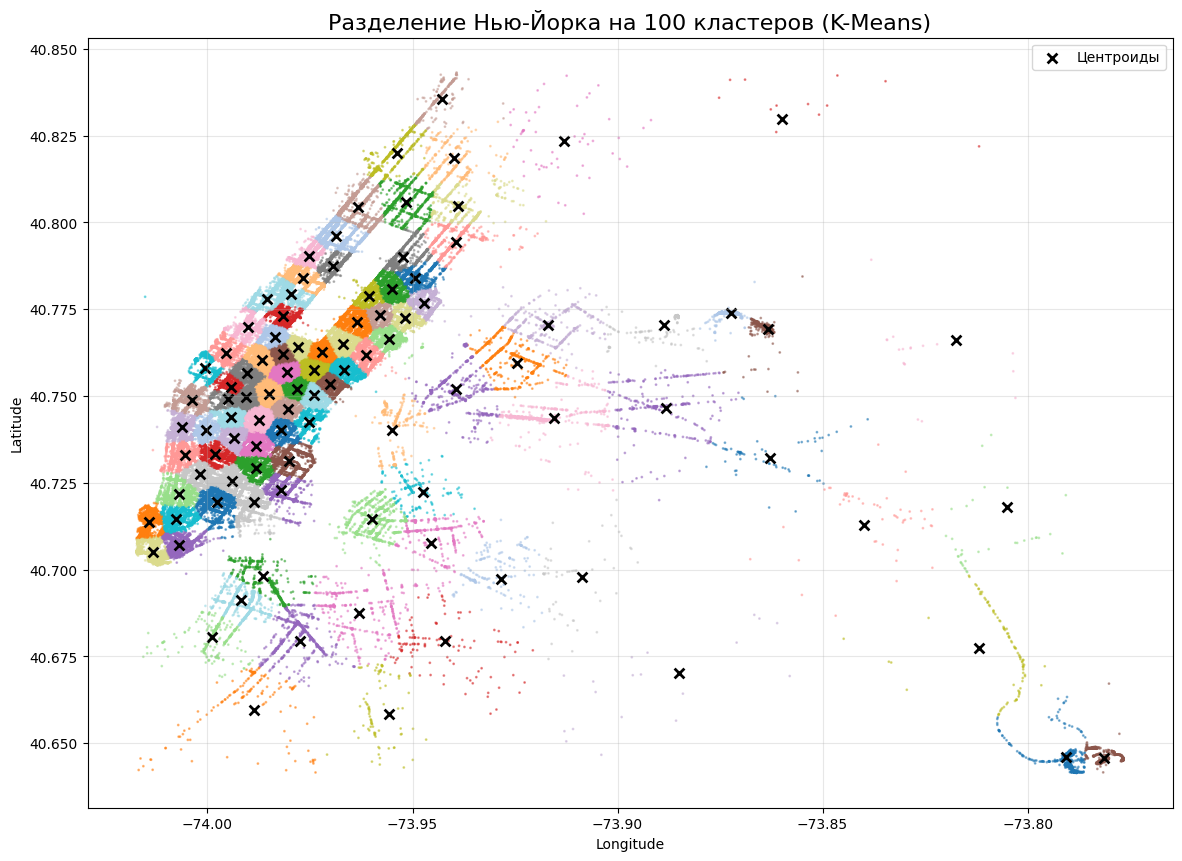

In [28]:
plt.figure(figsize=(14, 10))
sample_df = clean_dataset.sample(n=len(clean_dataset), random_state=42)

scatter = plt.scatter(
    sample_df['pickup_longitude'],
    sample_df['pickup_latitude'],
    c=sample_df['pickup_cluster'],
    cmap='tab20',
    s=1,
    alpha=0.5
)

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 1], centroids[:, 0],
    c='black', s=50, marker='x', linewidths=2, label='Центроиды'
)

plt.title('Разделение Нью-Йорка на 100 кластеров (K-Means)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
# Агрегируем поездки между кластерами
cluster_routes = clean_dataset.groupby(['pickup_cluster', 'dropoff_cluster']).agg(
    trips_count=('trip_duration', 'count'),
    avg_duration=('trip_duration', 'mean')
).reset_index()

# Убираем петли (поездки внутри одного кластера), чтобы не замусоривать график точками
cluster_routes = cluster_routes[cluster_routes['pickup_cluster'] != cluster_routes['dropoff_cluster']]

# Берем топ-2000 самых популярных маршрутов
top_cluster_routes = cluster_routes.nlargest(2000, 'trips_count')

print(f"Агрегировано уникальных межкластерных маршрутов: {len(cluster_routes)}")
display(top_cluster_routes.head())

Агрегировано уникальных межкластерных маршрутов: 7931


,pickup_cluster,dropoff_cluster,trips_count,avg_duration
845,10,22,409,324.325183
1807,22,10,370,438.064865
556,6,56,350,288.720000
834,10,11,342,533.216374
6913,87,59,339,287.023599


/tmp/ipykernel_399/3677124745.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cluster = cm.get_cmap('coolwarm')


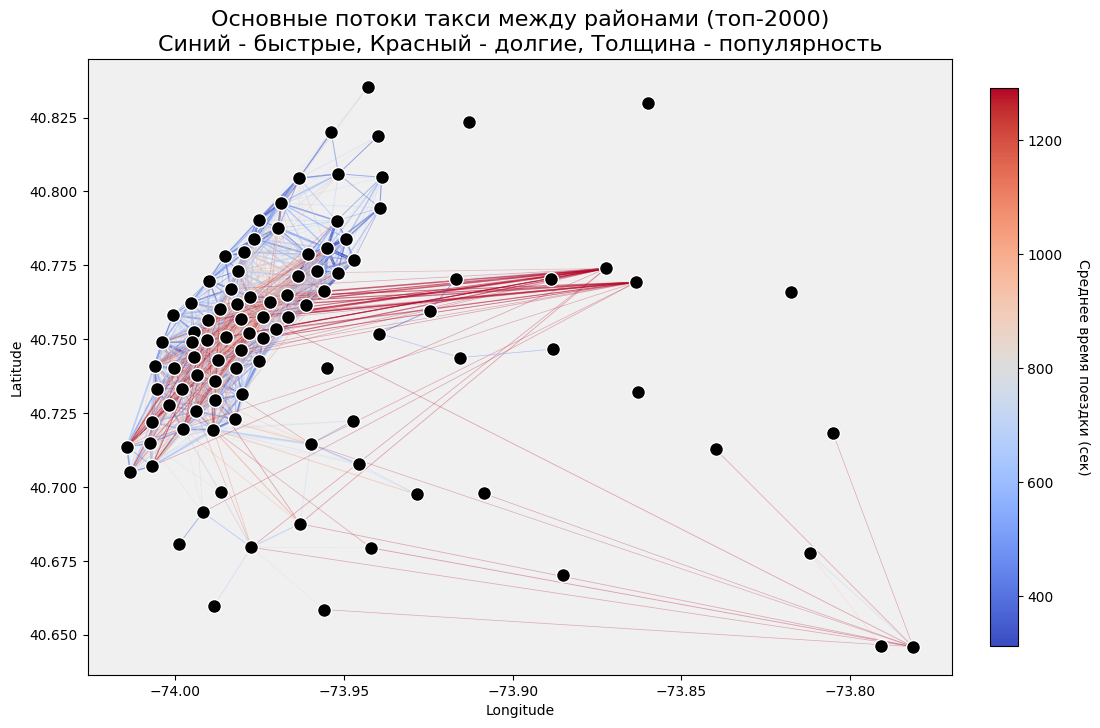

In [30]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.set_facecolor('#f0f0f0')

centroids = kmeans.cluster_centers_

# Нормализаторы для цвета (время) и ширины (количество)
norm_color_cluster = Normalize(vmin=top_cluster_routes['avg_duration'].quantile(0.05),
                               vmax=top_cluster_routes['avg_duration'].quantile(0.95))
norm_width_cluster = Normalize(vmin=top_cluster_routes['trips_count'].min(),
                               vmax=top_cluster_routes['trips_count'].max())

cmap_cluster = cm.get_cmap('coolwarm')

# Рисуем линии потоков
for _, row in top_cluster_routes.iterrows():
    p_idx = int(row['pickup_cluster'])
    d_idx = int(row['dropoff_cluster'])

    # Координаты начала (pickup) и конца (dropoff)
    p_coords = centroids[p_idx]
    d_coords = centroids[d_idx]

    # Цвет зависит от времени
    color = cmap_cluster(norm_color_cluster(row['avg_duration']))

    # Ширина и прозрачность зависят от популярности маршрута
    popularity_factor = norm_width_cluster(row['trips_count'])
    linewidth = 0.5 + popularity_factor * 3
    alpha = 0.3 + popularity_factor * 0.6

    # Рисуем линию
    ax.plot([p_coords[1], d_coords[1]], [p_coords[0], d_coords[0]],
             c=color, linewidth=linewidth, alpha=alpha, zorder=1)


# Рисуем сами центроиды кластеров поверх линий
ax.scatter(centroids[:, 1], centroids[:, 0], s=100, c='black', marker='o', edgecolors='white', zorder=2)

plt.title('Основные потоки такси между районами (топ-2000)\nСиний - быстрые, Красный - долгие, Толщина - популярность', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)

sm = cm.ScalarMappable(cmap=cmap_cluster, norm=norm_color_cluster)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Среднее время поездки (сек)', rotation=270, labelpad=20)

plt.show()

Очень популярное место -- снизу справа, туда ведёт очень много дорог. Похоже, много людей живут за границами Нью-Йорка, что абсолютно нормально.

Вроде как, мы разобрали все необходимые параметры, можно переходить к созданию пайплайна, чтобы в дальнейшем использоватьв в кафке.

## Разрабатываем пайплайны

In [31]:
clean_dataset.info()

<class 'pandas.DataFrame'>
Index: 240881 entries, 0 to 249999
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  240881 non-null  str           
 1   vendor_id           240881 non-null  int64         
 2   pickup_datetime     240881 non-null  datetime64[us]
 3   dropoff_datetime    240881 non-null  str           
 4   passenger_count     240881 non-null  int64         
 5   pickup_longitude    240881 non-null  float64       
 6   pickup_latitude     240881 non-null  float64       
 7   dropoff_longitude   240881 non-null  float64       
 8   dropoff_latitude    240881 non-null  float64       
 9   store_and_fwd_flag  240881 non-null  str           
 10  trip_duration       240881 non-null  int64         
 11  distance            240881 non-null  float64       
 12  speed               240881 non-null  float64       
 13  pickup_hour         240881 non-null  int32   

In [32]:
test_dataset.info()

<class 'pandas.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  250000 non-null  str    
 1   vendor_id           250000 non-null  int64  
 2   pickup_datetime     250000 non-null  str    
 3   passenger_count     250000 non-null  int64  
 4   pickup_longitude    250000 non-null  float64
 5   pickup_latitude     250000 non-null  float64
 6   dropoff_longitude   250000 non-null  float64
 7   dropoff_latitude    250000 non-null  float64
 8   store_and_fwd_flag  250000 non-null  str    
dtypes: float64(4), int64(2), str(3)
memory usage: 17.2 MB


In [33]:
def preprocess_taxi_data(X, kmeans_model=None):
    X_processed = X.copy()

    X_processed['pickup_datetime'] = pd.to_datetime(X_processed['pickup_datetime'])
    X_processed['pickup_hour'] = X_processed['pickup_datetime'].dt.hour
    X_processed['pickup_dayofweek'] = X_processed['pickup_datetime'].dt.dayofweek
    X_processed['pickup_month'] = X_processed['pickup_datetime'].dt.month

    X_processed["distance"] = manhattan_distance(
        X_processed['pickup_longitude'], X_processed['pickup_latitude'],
        X_processed['dropoff_longitude'], X_processed['dropoff_latitude']
    )

    if kmeans_model is not None:
        X_processed['pickup_cluster'] = kmeans_model.predict(X_processed[['pickup_latitude', 'pickup_longitude']])
        X_processed['dropoff_cluster'] = kmeans_model.predict(X_processed[['dropoff_latitude', 'dropoff_longitude']])

    if 'store_and_fwd_flag' in X_processed.columns:
        X_processed['store_and_fwd_flag'] = X_processed['store_and_fwd_flag'].map({'N': 0, 'Y': 1}).fillna(0).astype(int)

    drop_cols = ['id', 'pickup_datetime', 'dropoff_datetime', 'speed',
                 'pu_lat_r', 'pu_lon_r', 'do_lat_r', 'do_lon_r', 'outliers']
    cols_to_drop = [col for col in drop_cols if col in X_processed.columns]
    X_processed.drop(columns=cols_to_drop, inplace=True)

    cat_cols = ['vendor_id', 'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'pickup_cluster', 'dropoff_cluster']
    for col in cat_cols:
        if col in X_processed.columns:
            X_processed[col] = X_processed[col].astype(int)

    return X_processed

In [34]:
taxi_preprocessor = FunctionTransformer(
    preprocess_taxi_data,
    # kw_args={'kmeans_model': kmeans} по итогу никак на качество не повлияло вообще никак
)

In [35]:
raw_columns = [
    'id', 'vendor_id', 'pickup_datetime', 'passenger_count',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
    'dropoff_latitude', 'store_and_fwd_flag'
]

In [36]:
X = dataset[raw_columns]
y = dataset['trip_duration']

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train.shape, X_val.shape)

(175000, 9)

(75000, 9)

In [38]:
cat_features = [
    'vendor_id', 'store_and_fwd_flag', 'pickup_hour',
    'pickup_dayofweek', 'pickup_month', 'pickup_cluster', 'dropoff_cluster'
]
cat_features = [feature for feature in cat_features if feature in X_train.columns]

base_pipeline = Pipeline([
    ('preprocessor', taxi_preprocessor),
    ('model', CatBoostRegressor(
        iterations=1000,
        random_seed=42,
        verbose=100,
        depth=8,
        learning_rate=0.08,
    ))
])

taxi_pipeline = TransformedTargetRegressor(
    regressor=base_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

In [39]:
taxi_pipeline.fit(X_train, y_train, model__cat_features=cat_features)

0:	learn: 0.7581607	total: 62ms	remaining: 1m 1s
100:	learn: 0.4358514	total: 736ms	remaining: 6.55s
200:	learn: 0.4169126	total: 1.53s	remaining: 6.08s
300:	learn: 0.4060547	total: 2.41s	remaining: 5.6s
400:	learn: 0.3978935	total: 3.12s	remaining: 4.67s
500:	learn: 0.3914218	total: 3.84s	remaining: 3.82s
600:	learn: 0.3856505	total: 4.74s	remaining: 3.15s
700:	learn: 0.3810063	total: 5.51s	remaining: 2.35s
800:	learn: 0.3770051	total: 6.23s	remaining: 1.55s
900:	learn: 0.3729117	total: 7.13s	remaining: 783ms
999:	learn: 0.3691351	total: 8.01s	remaining: 0us


,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.",Pipeline(step...erbose=100))])
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",None
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",<ufunc 'log1p'>
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",<ufunc 'expm1'>
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function pre...x73c030d2aca0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None


In [40]:
# Проверяем на валидации
y_pred = taxi_pipeline.predict(X_val)
print(f"MAE%: ", mean_absolute_percentage_error(y_val, y_pred))

MAE%:  0.3005133460389742


У нас средняя ошибка -- 25% по времени. В целом, выглядит как адекватная ошибка, учитывая, что из-за пробок возникают разные ошибки. Можно двигаться дальше. Сохранить его и потом использовать в кафке.

In [41]:
joblib.dump(taxi_pipeline, 'models/taxi_pipeline.pkl')

['models/taxi_pipeline.pkl']

In [42]:
test_row_df = test_dataset.iloc[[0]]
prediction = taxi_pipeline.predict(test_row_df)

print(f"Предсказание для первой строки теста: {prediction[0]:.2f} секунд")

Предсказание для первой строки теста: 852.19 секунд
